In [1]:
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import losses, layers, models, metrics, Model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from keras import backend as K
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import torch
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
files = []
for i in range(6):
    name =  ''
    if i == 5:
        name = 'cifar-10-batches-py/test_batch'
    else:
        name = 'cifar-10-batches-py/data_batch_' + str(i + 1)
    files.append(unpickle(name))

In [23]:
rotations_num = 4
saved_name = 'selfsupervised'
selfsupervised_epochs = 60
selfsupervised_batch_size = 128
supervised_epochs = 60
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

In [5]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [6]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [7]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[data_len * i + j][files[i][b"labels"][j]] = 1.
        for k in range(files[i][b"data"].shape[1]):
            combined_data[data_len * i + j][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[data_len * i + j] = 0
        for t in range(1, rotations_num):
            true_labels[60000 * t + data_len * i + j][files[i][b"labels"][j]] = 1.
            combined_data[60000 * t + data_len * i + j] = np.rot90(combined_data[data_len * i + j], t)
            combined_labels[60000 * t + data_len * i + j][t] = 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


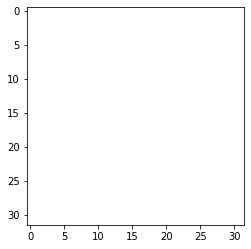

In [8]:
plt.imshow(combined_data[random.randint(0, 49999)])
plt.show()

In [26]:
combined_data = preprocess_input(combined_data)

In [ ]:
print(combined_labels[99009])

[0. 1. 0. 0.]


In [8]:
def plot_training(**kwargs):
    plt.figure(figsize = (10, 10))
    for k, v in kwargs.items():
        if k != 'name' and k != 'filename':
            plt.plot(v, label=k)
    plt.grid(True)
    if 'name' in kwargs:
        plt.title(kwargs['name'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    if 'filename' in kwargs:
        plt.savefig(kwargs['filename'])

In [9]:
def get_feat_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3))(inputs)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3))(x)
    #x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), name = 'conv_feat')(x)
    #x = layers.BatchNormalization()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256)(x)
    #x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(rotations_num, activation = 'softmax')(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [10]:
def get_conv_model():
    base = ResNet50(include_top=False, weights=None)
    l = base.output
    l = layers.GlobalAveragePooling2D(name = 'conv_feat')(l)
    l = layers.Flatten()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(256, kernel_regularizer=regularizers.l1_l2(l1 = 0.001, l2 = 0.01))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('sigmoid')(l)
    l = layers.Dropout(0.3)(l)
    l = layers.Dense(rotations_num, kernel_regularizer=regularizers.l1_l2(l1 = 0.001, l2 = 0.01), activation = 'softmax')(l)
    
    return tf.keras.Model(inputs = base.input, outputs = l)

In [11]:
def lr_schedule(epoch):
    if epoch > 50:
        return 0.0003
    if epoch > 40:
        return 0.001
    if epoch > 30:
        return 0.003
    return 0.01

In [12]:
def train_feat():
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    log = model.fit(combined_data, combined_labels, 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, 
                    shuffle = True, callbacks = [LearningRateScheduler(lr_schedule)])
    model.save(saved_name)
    return log

In [ ]:
log = train_feat()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
__________

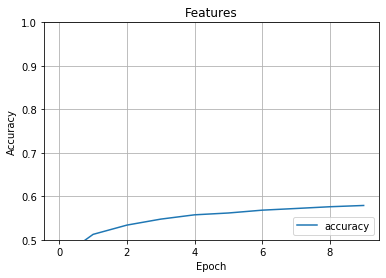

In [ ]:
plot_training(accuracy = log.history['acc'], name = 'Features')

In [28]:
def get_cls_model(name = saved_name):
    model = tf.keras.models.load_model(name)
    l = model.get_layer('conv_feat').output
    l = layers.Flatten()(l)
    #l = layers.Dropout(0.5)(l)
    #l = layers.Dense(256, kernel_regularizer=regularizers.l1_l2(l1 = 0.001, l2 = 0.01))(l)
    #l = layers.BatchNormalization()(l)
    #l = layers.Activation('sigmoid')(l)
    l = layers.Dropout(0.3)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.001, l2 = 0.01), activation = 'softmax')(l)
    return tf.keras.Model(inputs = model.input, outputs = l)

In [14]:
def train_cls(train_features = True):
    cls_model = get_cls_model()
    cls_model.summary()
    if not train_features:
        for l in cls_model.layers[:-5]:
            l.trainable = False
    cls_model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(combined_data[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            true_labels[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            callbacks = [LearningRateScheduler(lr_schedule)],
                            validation_data = (combined_data[int(60000 * (1.0 - supervised_trainval_ratio)):60000], 
                                               true_labels[int(60000 * (1.0 - supervised_trainval_ratio)):60000]))
    return cls_log

In [ ]:
cls_train_features = train_cls(True)

In [ ]:
cls_no_train_features = train_cls(False)

In [ ]:
plot_training(name = 'Train accuracy',
              fine_tuning_accuracy = cls_train_features.history['acc'],
              feature_extracting_accuracy = cls_no_train_features.history['acc'])

In [ ]:
plot_training(name = 'Validation accuracy',
              fine_tuning_accuracy = cls_train_features.history['val_acc'],
              feature_extracting_accuracy = cls_no_train_features.history['val_acc'])

In [15]:
labelsPercent = [50, 25, 10, 5, 1]

In [16]:
def shuffle_examples():
    #Перемешивание датасета для выбора размеченных экземпляров, т.к. выбираются первые n элементов
    for i in range(len(examplesForClass)):
        random.shuffle(examplesForClass[i])

In [17]:
def generate_labeled_unlabeled(examples, percent, shuffle = True):
    #Равномерное по классам распределение на размеченную и неразмеченную часть с заданным процентом
    if shuffle:
        shuffle_examples()
    labeled = []
    tmp = []
    unlabeled = []

    for i in range(len(examples)):
        labeled += examples[i][5000 - percent * 50 :] #50 == 5000 / 100
        tmp += examples[i][percent * 50 :] #50 == 5000 / 100
    
    for i in range(rotations_num):
        unlabeled += [tmp[j] + 60000 * i for j in range(len(tmp))]
        
    return labeled, unlabeled

In [18]:
def self_supervised_train(unlabeled, percent):
    if percent >= 100:
        return None
    
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    log = model.fit(np.asarray([combined_data[i] for i in unlabeled]), 
                    np.asarray([combined_labels[i] for i in unlabeled]), 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, shuffle = True,
                    callbacks = [LearningRateScheduler(lr_schedule)])
    model.save(saved_name + "_" + str(percent))
    
    return log

In [26]:
def fine_tune(labeled, percent, train_features = True):
    cls_model = get_cls_model(saved_name + "_" + str(percent)) \
        if percent < 100 \
        else get_empty_model()
    cls_model.summary()
    
    if not train_features:
        for l in cls_model.layers[:-5]:
            l.trainable = False
            
    cls_model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(np.asarray([combined_data[i] for i in labeled]), 
                            np.asarray([true_labels[i] for i in labeled]), 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            callbacks = [LearningRateScheduler(lr_schedule)],
                            validation_data = (combined_data[50000:60000], 
                                               true_labels[50000:60000]))
    
    return cls_log

In [20]:
def get_empty_model():
    #Непредобученная модель на случай использования всей разметки
    model = get_conv_model()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    model.save(saved_name + "_100")
    
    return get_cls_model(saved_name + "_100")

In [21]:
examplesForClass = []
for i in range(10):
    examplesForClass.append([j for j in range(50000) if np.where(true_labels[j] == 1)[0][0] == i])

In [ ]:
logs = []
cls_logs = []

for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, p)
    if not os.path.isfile(saved_name + "_" + str(p)):
        logs.append(self_supervised_train(unlabeled, p))
    cls_logs.append(fine_tune(labeled, p, True))        

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Train on 25000 samples, validate on 10000 samples
Epoch 1/60
25000/25000 [==============================] - 29s 1ms/sample - loss: 13.9774 - acc: 0.1471 - val_loss: 13.6362 - val_acc: 0.1637
Epoch 2/60
25000/25000 [==============================] - 16s 645us/sample - loss: 13.7414 - acc: 0.1574 - val_loss: 13.5578 - val_acc: 0.1707
Epoch 3/60
25000/25000 [==============================] - 16s 647us/sample - loss: 13.2651 - acc: 0.1881 - val_loss: 12.9650 - val_acc: 0.2044
Epoch 4/60
25000/25000 [==============================] - 17s 678us/sample - loss: 12.8908 - acc: 0.2075 - val_loss: 12.6647 - val_acc: 0.2193
Epoch 5/60
25000/25000 [==============================] - 17s 675us/sample - loss: 9.3086 - acc: 0.2180 - val_loss: 3.3014 - val_acc: 0.1689
Epoch 6/60
25000/25000 [==============================] - 16s 659us/sample - loss: 2.7832 - acc: 0.2967 - val_loss: 3.6562 - val_acc: 0.1820
Epoch 7/60
25000/25000 [==============================] - 17s 671us/sample - loss: 2.0779 - acc: 0

In [ ]:
plot_dict = {}

for i, p in enumerate(labelsPercent):
    plot_dict["labels_" + str(p)] = cls_logs[i].history['val_acc']

In [ ]:
plot_training(name = 'Validation accuracy',
              filename = 'self_part_labels',
              **plot_dict)

In [ ]:
logs_supervised = []
cls_logs_supervised = []

for p in labelsPercent:
    labeled, unlabeled = generate_labeled_unlabeled(p)
    logs_supervised.append(self_supervised_train(unlabeled, 100))
    cls_logs_supervised.append(fine_tune(labeled, 100))

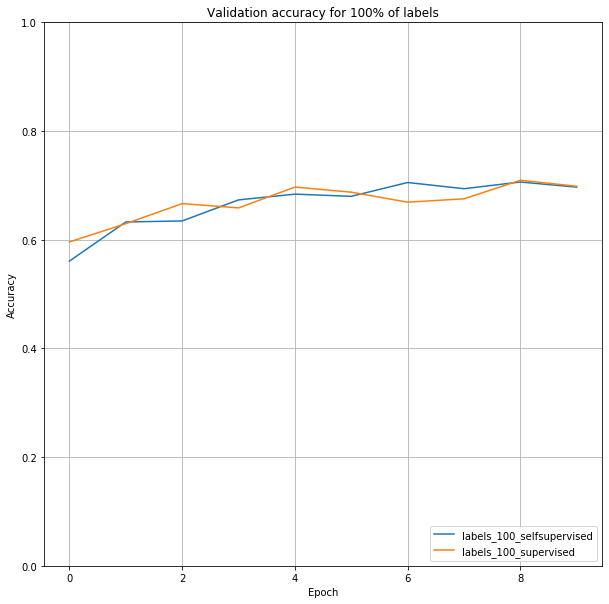

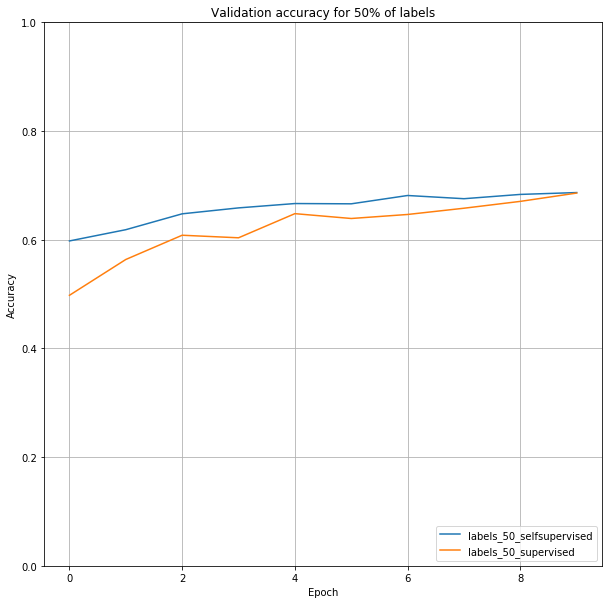

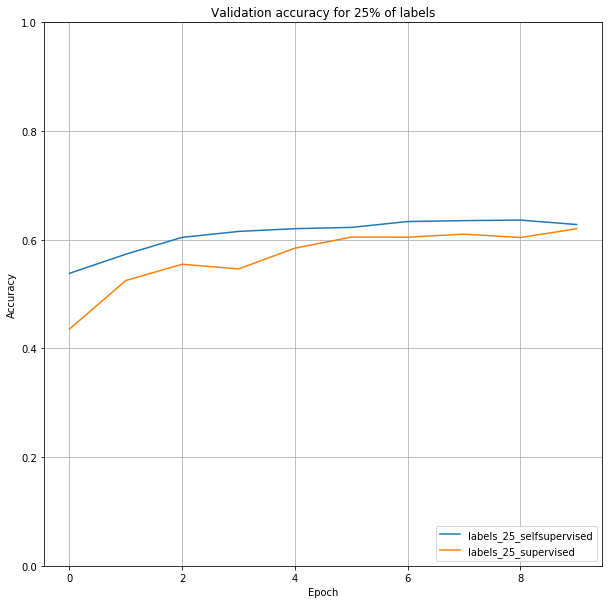

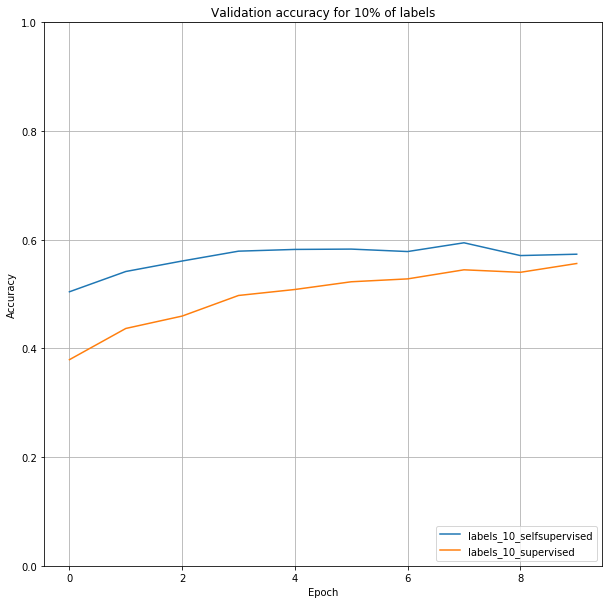

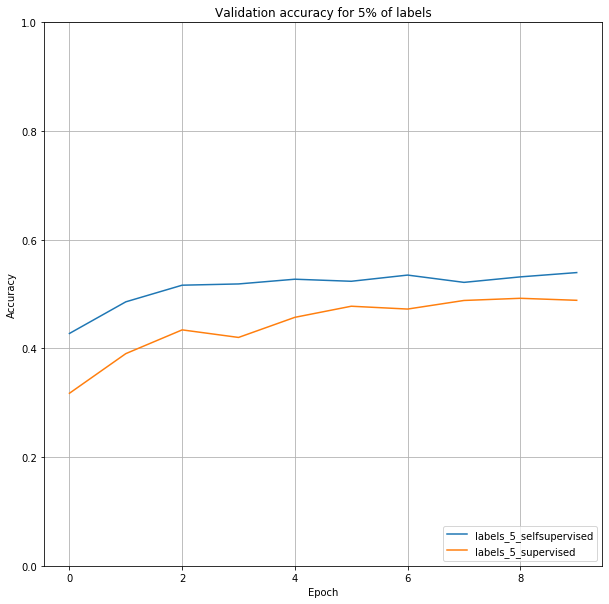

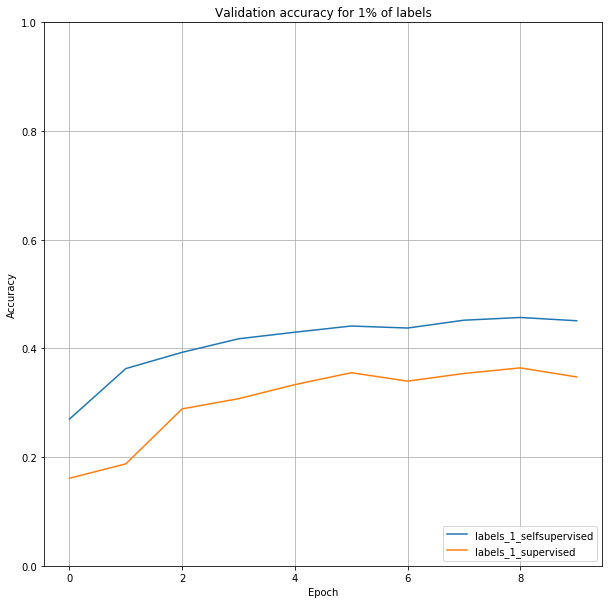

In [ ]:
for i, p in enumerate(labelsPercent):
    plot_dict = {}
    
    plot_dict["labels_" + str(p) + "_selfsupervised"] = cls_logs[i].history['val_acc']
    plot_dict["labels_" + str(p) + "_supervised"] = cls_logs_supervised[i].history['val_acc']
    
    plot_training(name = 'Validation accuracy for ' + str(p) + "% of labels",
                  filename = 'self_and_default_' + str(p) + " labels",
                  **plot_dict)

In [12]:
currentPercent = 100

unsupervised_threshold = 0.95
unsupervised_loss_coef = 1.0

semisupervised_epochs = 50
semisupervised_batch_size = 128

In [13]:
labelsPercent = [50, 25, 10, 5, 1]

In [14]:
class Augmentator():
    def __init__(self, N, M):
        self.N = N
        self.M = M
        self.transformations = [identity, autoContrast, equalize, rotate, solarize, color, posterize, contrast, brightness, sharpness, shearX, shearY, translateX, translateY]

    def __call__(self, img):
        chosen_transformations = random.choises(self.transformations, self.N)
        for t in chosen_transformations:
            img = self.t(img)
        return img

    def shearX(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, (random.choice([-1, 1])) * M * 0.3, 0, 0, 1, 0))

    def shearY(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, (random.choice([-1, 1])) * M * 0.3, 1, 0))

    def translateX(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, (random.choice([-1, 1])) * M * 0.3 * img.size[0], 0, 1, 0))

    def translateY(self, img):
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, (random.choice([-1, 1])) * M * 0.3 * img.size[0]))

    def rotate(self, img):
        return img.rotate((random.choice([-1, 1])) * M * 30.0)

    def autoContrast(self, img):
        return PIL.ImageOps.autocontrast(img)

    def invert(self, img):
        return PIL.ImageOps.invert(img)

    def equalize(self, img):
        return PIL.ImageOps.equalize(img)

    def solarize(self, img):
        return PIL.ImageOps.solarize(img, M * 256.0)

    def posterize(self, img):
        return PIL.ImageOps.posterize(img, M * 4.0)

    def contrast(self, img):
        return PIL.ImageEnhance.Contrast(img).enhance(M)

    def color(self, img):
        return PIL.ImageEnhance.Color(img).enhance(M)

    def brightness(self, img):
        return PIL.ImageEnhance.Brightness(img).enhance(M)

    def sharpness(self, img):
        return PIL.ImageEnhance.Sharpness(img).enhance(M)

In [15]:
examplesForClass = []
for i in range(10):
    examplesForClass.append([j for j in range(50000) if np.where(true_labels[j] == 1)[0][0] == i])

In [16]:
def is_called(func):
    def newfunc(*args, **kwargs):
        print('Called func!')
        func(args, kwargs)
    return newfunc

In [17]:
def custom_loss(y_true, y_pred):
    with tf.GradientTape() as tape:
        return tf.math.reduce_sum(tf.multiply(y_true, tf.math.log(y_pred)))

In [18]:
#loss_tracker = metrics.CategoricalCrossentropy(name="loss")
acc_metric = metrics.Accuracy(name="acc")

#loss_tracker_supervised = metrics.CategoricalCrossentropy(name="loss_sup")
acc_metric_supervised = metrics.Accuracy(name="acc_sup")

#loss_tracker_unsupervised = metrics.CategoricalCrossentropy(name="loss_unsup")
acc_metric_unsupervised = metrics.Accuracy(name="acc_unsup")


class CustomModel(Model):
    @is_called
    def train_step(self, data):
        X, Y = data
        print(X)
        X = tf.unstack(X)

        print('Going to tape')

        x_supervised = np.asarray([combined_data[i] for i in X if i in labeled])
        x_unsupervised = np.asarray([combined_data[i] for i in X if i in unlabeled])
        x_augmented = x_unsupervised
        y_true_supervised = np.asarray([true_labels[i] for i in X if i in labeled])

        #Supervised part
        with tf.GradientTape() as tape:
            tape.watch(x_supervised)

            y_pred_supervised = self(x_supervised, training=True)  
            loss_supervised = custom_loss(y_true_supervised, y_pred_supervised)

            #Unsupervised part
            tape.watch(x_augmented)
            y_pred = self(x_unsupervised, training=False)

            #y_pred_np = tf.make_ndarray(y_pred.op.get_attr('value'))
            y_pred_unsupervised = self(x_augmented, training=True) #if max(y_pred_np[i]) > unsupervised_threshold)
            
            loss_unsupervised = custom_loss(y_pred, y_pred_unsupervised)

            #Loss
            #loss, grads = custom_loss(self, y_true_supervised, y_pred, y_pred_supervised, y_pred_unsupervised)
            loss = loss_supervised + loss_unsupervised * unsupervised_loss_coef
            grads = tape.gradient(loss, self.trainable_variables)

            #Weights
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        #Metrics
        #loss_tracker_supervised.update_state(loss_supervised)
        acc_metric_supervised.update_state(y_true_supervised, y_pred_supervised)

        #loss_tracker_unsupervised.update_state(loss_unsupervised)
        acc_metric_unsupervised.update_state(y_pred, y_pred_unsupervised)

        #loss_tracker.update_state(loss)
        #acc_metric.update_state(np.concatenate(y_pred, y_true_supervised), np.concatenate(y_pred_unsupervised, y_pred_supervised))

        return {#"loss_supervised": loss_tracker_supervised.result(), 
                "acc_supervised": acc_metric_supervised.result(), 
                #"loss_unsupervised": loss_tracker_unsupervised.result(), 
                "acc_unsupervised": acc_metric_unsupervised.result()}

    @property
    def metrics(self):
        return [#loss_tracker, 
            acc_metric]



Instructions for updating:
Colocations handled automatically by placer.


In [19]:
#augmentator = Augmentator(2, random.random())
#augmented_data = []
#for c in combined_data:
#    augmented_data.append(np.array(augmentator(Image.fromarray(np.uint8(c * 255.0)))))
#augmented_data = np.asarray(augmented_data)

augmented_data = combined_data

In [20]:
def get_semi_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), name = 'conv_feat')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(10, activation = 'softmax')(x)
    
    return CustomModel(inputs = inputs, outputs = x)

In [21]:
def get_resnet_model():
    base = ResNet50(include_top=False, weights=None)
    l = base.output
    l = layers.GlobalAveragePooling2D()(l)
    l = layers.Flatten()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(256, kernel_regularizer=regularizers.l1_l2(l1 = 0.001, l2 = 0.01))(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('sigmoid')(l)
    l = layers.Dropout(0.3)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.001, l2 = 0.01), activation = 'softmax')(l)

    return CustomModel(inputs = base.input, outputs = l)

In [22]:
logs_resnet = []
for p in labelsPercent:
    currentPercent = p
    shuffle_examples()
    print('Shuffled')
    labeled, unlabeled = generate_labeled_unlabeled(examplesForClass, currentPercent, False)
    print('Generated')
    #x_supervised = tf.convert_to_tensor([combined_data[i] for i in labeled])
    #x_unsupervised = tf.convert_to_tensor([combined_data[i] for i in unlabeled])
    #x_augmented = tf.convert_to_tensor([augmented_data[i] for i in unlabeled])
    #print('X converted')

    #y_true_supervised = tf.convert_to_tensor([true_labels[i] for i in labeled])
    #y_pred = tf.constant([0.])
    #y_pred_supervised = tf.constant([0.])
    #y_pred_unsupervised = tf.constant([0.])

    model = get_resnet_model()
    model.compile(optimizer = optimizers.SGD(lr=0.05, momentum=0.9, decay=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    model.fit(tf.convert_to_tensor(combined_data[:50000]), 
                tf.convert_to_tensor(true_labels[:50000]), 
                epochs = semisupervised_epochs, batch_size = semisupervised_batch_size, shuffle = True,
                steps_per_epoch = 5,
                validation_data = (np.asarray(combined_data[50000:60000]), 
                                    np.asarray(true_labels[50000:60000])))

Shuffled
Generated
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\Alexander\.conda\envs\keras-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Instructions for updating:
Use tf.cast instead.
Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[50000,64,16,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node bn_conv1/cond/FusedBatchNorm}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/dense_1_loss/broadcast_weights/assert_broadcastable/is_valid_shape/has_valid_nonscalar_shape/has_invalid_dims/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
